<a href="https://colab.research.google.com/github/bphqk3/CF/blob/main/CF_PTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This aims to cluster only active players in the 2023-2024 season. Players will be dropped entirely in previous seasons if they're not in the league anymore**

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr  5 01:34:00 2024

@author: Brooke
"""

import pandas as pd
import time
from io import StringIO
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, Ridge, ElasticNetCV, ElasticNet, BayesianRidge, LogisticRegression, SGDRegressor, RidgeClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.experimental import enable_hist_gradient_boosting  # Enable the module
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pickle
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import plotly.graph_objects as go


# make consolidated season stats list

*   structures are different in each. Manually drop irrelevant or duplicated columns before merging per the stat in interest (PTS). Add prefixes where necessary





In [5]:
a = pd.read_parquet('/home/S2122/player_stat_history_traditional2122.parquet')
a
a.columns

Index(['Player', 'Name', 'Unnamed: 0', 'Team', 'Age', 'GP', 'W', 'L', 'Min',
       'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%',
       'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2',
       'TD3', '+/-', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'PTS RANK',
       'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
       'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
       'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'PF RANK',
       'FP RANK', 'DD2 RANK', 'TD3 RANK', '+/- RANK'],
      dtype='object')

In [6]:
a = a.drop(['Name', 'Unnamed: 0', 'Team', 'Age', 'W', 'L','FGM','3PM','FTM',
            'OREB','DREB','REB','AST','TOV','STL','BLK','DD2','TD3', 'PF','FP',
            'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
            'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
            'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'PF RANK',
            'FP RANK', 'DD2 RANK', 'TD3 RANK', '+/- RANK','+/-', 'GP RANK', 'W RANK', 'L RANK',
            'MIN RANK', 'PTS RANK'],axis = 1)
a



,Player,GP,Min,PTS,FGA,FG%,3PA,3P%,FTA,FT%
0,Aaron Gordon,75,48.4,22.9,17.0,52.0,5.3,33.5,4.7,74.3
1,Aaron Henry,6,44.7,5.3,13.2,20.0,2.6,0.0,0.0,0.0
2,Aaron Holiday,63,48.3,18.9,16.0,44.7,4.9,37.9,3.2,86.8
3,Aaron Nesmith,52,48.0,16.4,15.2,39.6,9.6,27.0,2.2,80.8
4,Aaron Wiggins,50,47.5,16.3,13.2,46.3,5.4,30.4,3.3,72.9
...,...,...,...,...,...,...,...,...,...,...
600,Zach LaVine,67,48.2,33.9,24.6,47.6,9.8,38.9,7.8,85.3
601,Zavier Simpson,4,49.2,12.4,14.7,36.5,2.3,12.5,1.4,100.0
602,Zeke Nnaji,41,48.3,18.7,12.9,51.6,5.5,46.3,4.5,63.1
603,Ziaire Williams,62,46.5,17.3,14.6,45.0,8.4,31.4,1.9,78.2


In [ ]:
b = pd.read_parquet('/home/S2122/player_stat_history_drives2122.parquet')
b
b.columns

In [ ]:
b = b.drop(['Name', 'Team', 'GP', 'W', 'L', 'MIN','FGM', 'FGA',
       'FG%', 'FTM', 'FTA', 'FT%', 'PTS', 'PTS%', 'PASS', 'PASS%', 'AST',
       'AST%', 'TO', 'TOV%', 'PF', 'PF%'], axis = 1)
b.rename(columns={'DRIVES':'DrivesPG'}, inplace = True)

#got rid of "misc" stats (c)

#got rid of "passing" stats (d)
b


In [ ]:
# move to an only shooting dataset to cluster players for PTS analysis, so remove c
# c = pd.read_parquet('/home/S2122/player_stat_history_passing2122.parquet')
# c

# move to an only shooting dataset to cluster players for PTS analysis, so remove e
# d = pd.read_parquet('/home/S2122/player_stat_history_rebounding2122.parquet')
# d

# remove in favor for actual 'shooting' stats collected from nba.com
# e = pd.read_parquet('/home/S2122/player_stat_history_misc2122.parquet')
# e

In [7]:
f = pd.read_parquet('/home/S2122/player_stat_history_scoring2122.parquet')
f

,Player,Name,Unnamed: 0,Team,AGE,GP,W,L,MIN,%FGA 2PT,...,%PTS FBPs RANK,%PTS FT RANK,%PTS OffTO RANK,%PTS PITP RANK,2FGM %AST RANK,2FGM %UAST RANK,3FGM %AST RANK,3FGM %UAST RANK,FGM %AST RANK,FGM %UAST RANK
0,Aaron Gordon,A. Gordon,46,DEN,26,75,46,29,31.7,68.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Henry,A. Henry,521,PHI,22,6,6,0,2.8,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Holiday,A. Holiday,184,PHX,25,63,34,29,16.2,69.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aaron Nesmith,A. Nesmith,273,BOS,22,52,32,20,11.0,36.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aaron Wiggins,A. Wiggins,289,OKC,23,50,13,37,24.2,59.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,Zach LaVine,Z. LaVine,132,CHI,27,67,37,30,34.7,59.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601,Zavier Simpson,Z. Simpson,535,OKC,25,4,1,3,43.5,84.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602,Zeke Nnaji,Z. Nnaji,348,DEN,21,41,24,17,17.0,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603,Ziaire Williams,Z. Williams,192,MEM,20,62,41,21,21.7,42.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
f = f.drop(columns=['Name', 'Unnamed: 0', 'Team', 'AGE', 'GP','W', 'L', 'MIN',
       '%PTS FBPs', '%PTS OFFTO', '%PTS PITP', '2FGM %AST',
       '2FGM %UAST', '3FGM %AST', '3FGM %UAST', 'FGM %AST', 'FGM %UAST',
       'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', '%FGA 2PT RANK',
       '%FGA 3PT RANK', '%PTS 2PT RANK','%PTS 3PT RANK',
       '%PTS FBPs RANK', '%PTS FT RANK', '%PTS OffTO RANK', '%PTS PITP RANK',
       '2FGM %AST RANK', '2FGM %UAST RANK', '3FGM %AST RANK',
       '3FGM %UAST RANK', 'FGM %AST RANK', 'FGM %UAST RANK'],axis = 1)
idrop = [4,7]
f = f.drop(f.columns[idrop], axis=1)
f.rename(columns={'%FGA 2PT':'%FGA 2PT PG', '%FGA 3PT':'%FGA 3PT PG','%PTS 2PT':'%PTS 2PT PG', '%PTS 3PT':'%PTS 3PT PG','%PTS FT':'%PTS FT PG'}, inplace = True)
f


,Player,%FGA 2PT PG,%FGA 3PT PG,%PTS 2PT PG,%PTS 3PT PG,%PTS FT PG
0,Aaron Gordon,68.8,31.2,61.6,23.2,15.2
1,Aaron Henry,80.0,20.0,100.0,0.0,0.0
2,Aaron Holiday,69.5,30.5,56.0,29.3,14.7
3,Aaron Nesmith,36.8,63.2,41.8,47.4,10.8
4,Aaron Wiggins,59.1,40.9,54.8,30.3,14.9
...,...,...,...,...,...,...
600,Zach LaVine,59.9,40.1,46.5,33.9,19.6
601,Zavier Simpson,84.6,15.4,81.8,6.8,11.4
602,Zeke Nnaji,57.0,43.0,43.7,41.1,15.2
603,Ziaire Williams,42.9,57.1,45.9,45.5,8.6


In [ ]:
g = pd.read_parquet('/home/S2122/player_stat_history_shooting2122.parquet')
g


In [ ]:
g = g.drop(columns=['Name', 'Team', 'Age', 'RA_FGM','PiPnRA_FGM','MR_FGM','LC3_FGM','RC3_FGM','C3_FGM','AB3_FGM'],axis=1)
suffix = ' PG'
g.columns.values[1:] = [col + suffix for col in g.columns[1:]]
g = g.replace('-', 0)
g.iloc[:, 1:] = g.iloc[:, 1:].apply(pd.to_numeric)
g



In [9]:
#we can drop (i), i believe i was usage stats (https://www.nba.com/stats/players/usage)
j = pd.read_parquet('/home/S2122/player_stat_history_advanced2122.parquet')
j


,Player,Name,Unnamed: 0,Team,AGE,GP,W,L,MIN,OFFRTG,...,eFG% RANK,TS% RANK,USG% RANK,PACE RANK,PIE RANK,FGM RANK,FGA RANK,FGM PG RANK,FGA PG RANK,FG% RANK
0,Aaron Gordon,A. Gordon,46,DEN,26,75,46,29,31.7,117.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Henry,A. Henry,521,PHI,22,6,6,0,2.8,71.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Holiday,A. Holiday,184,PHX,25,63,34,29,16.2,106.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aaron Nesmith,A. Nesmith,273,BOS,22,52,32,20,11.0,107.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aaron Wiggins,A. Wiggins,289,OKC,23,50,13,37,24.2,104.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,Zach LaVine,Z. LaVine,132,CHI,27,67,37,30,34.7,112.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601,Zavier Simpson,Z. Simpson,535,OKC,25,4,1,3,43.5,98.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602,Zeke Nnaji,Z. Nnaji,348,DEN,21,41,24,17,17.0,107.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603,Ziaire Williams,Z. Williams,192,MEM,20,62,41,21,21.7,112.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
j = j.drop(['Name', 'Unnamed: 0', 'Team', 'AGE', 'GP', 'W', 'L', 'MIN', 'OFFRTG', 'DEFRTG', 'NETRTG', 'EFG%', 'AST/TO','PIE','POSS', 'AST%', 'REB%', 'FGM',
        'FGA', 'FG%', 'GP RANK', 'W RANK','L RANK', 'MIN RANK', 'OFFRTG RANK', 'DEFRTG RANK', 'NETRTG RANK',
        'AST% RANK', 'AST/TO RANK', 'OREB% RANK',
        'DREB% RANK', 'REB% RANK', 'eFG% RANK', 'TS% RANK',
        'USG% RANK', 'PACE RANK', 'PIE RANK', 'FGM RANK',
        'FG% RANK','OREB%','DREB%',],axis=1)
j = j.drop(j.columns[[1,2,6,7,8,9,10,11,12]], axis=1)
j

,Player,TS%,USG%,PACE
0,Aaron Gordon,60.2,19.4,99.00
1,Aaron Henry,20.0,14.9,105.99
2,Aaron Holiday,54.4,18.2,99.57
3,Aaron Nesmith,50.7,16.4,100.58
4,Aaron Wiggins,55.6,14.9,101.60
...,...,...,...,...
600,Zach LaVine,60.5,28.4,99.36
601,Zavier Simpson,40.6,15.8,97.75
602,Zeke Nnaji,62.9,14.6,99.25
603,Ziaire Williams,55.9,14.4,103.22


### Clutch players - NOT RUNNING (4/7/24)


*   use for playoffs?
*   List item



In [ ]:
h = pd.read_parquet('/home/S2122/player_stat_history_clutch-usage2122.parquet')
h

In [ ]:
h = h.drop(['Name', 'Unnamed: 0', 'Team', 'AGE', 'GP', 'W', 'L', '%FGM', '%FGA', '%3PM', '%3PA', '%FTM', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK',
          '%FTA', '%OREB','%DREB', '%TOV', '%STL', '%BLK', '%BLKA', '%PF', '%PFD','GP RANK', 'W RANK',
            'L RANK', 'MIN RANK', 'USG% RANK','%FGM RANK', '%FGA RANK', '%3PM RANK', '%3PA RANK', '%FTM RANK',
            '%FTA RANK', '%OREB RANK', '%DREB RANK', '%REB RANK', '%AST RANK','%TOV RANK',
            '%STL RANK', '%BLK RANK', '%BLKA RANK', '%PF RANK','%PFD RANK', '%PTS RANK','MIN'],axis = 1)

#capture the players that are clutch; fill non-clutch players with zeros for their stats when we merge
h['PLAYER'] = 1
new_names = [(i,'Clutch_Game_'+i) for i in h.iloc[:, 1:].columns.values]
h.rename(columns = dict(new_names), inplace=True)

k = pd.read_parquet(r'C:/Users/Brooke/Desktop/rbt/rbt_player_history/nbacom/season_history/S2122/player_stat_history_clutch-advanced2122.parquet')
k

In [ ]:
k = k.drop(['Name', 'Unnamed: 0', 'Team', 'AGE', 'GP', 'W', 'L', 'MIN', 'AST/TO', 'FGM',
            'OffRtg', 'DefRtg', 'NetRtg', 'AST%', 'REB%','eFG%',
            'FGA', 'FG%', 'GP RANK', 'W RANK','L RANK', 'MIN RANK',
            'AST% RANK', 'AST/TO RANK', 'OREB% RANK',
            'DREB% RANK', 'REB% RANK', 'eFG% RANK', 'TS% RANK',
            'USG% RANK', 'PACE RANK', 'PIE RANK', 'FGM RANK',
            'FG% RANK','OREB%','DREB%',],axis=1)
kdrop = [1,2]
k = k.drop(k.columns[kdrop], axis=1).iloc[:,:5]
new_names = [(i,'Clutch_Game_'+i) for i in k.iloc[:, 1:].columns.values]
k.rename(columns = dict(new_names), inplace=True)

l = pd.read_parquet(r'C:/Users/Brooke/Desktop/rbt/rbt_player_history/nbacom/season_history/S2122/player_stat_history_clutch-traditional2122.parquet')
l

In [ ]:
l = l.drop(['Name', 'Unnamed: 0', 'Team','GP', 'W', 'L','FGM','3PM','FTM','FP',
            'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
            'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
            'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'PF RANK',
            'DD2 RANK', 'TD3 RANK', '+/- RANK','+/-', 'GP RANK', 'W RANK', 'L RANK',
            'MIN RANK', 'PTS RANK','Age'],axis = 1)
new_names = [(i,'Clutch_Game_'+i) for i in l.iloc[:, 1:].columns.values]
l.rename(columns = dict(new_names), inplace=True)

S2122_Player_Stats = pd.merge(a, j, on='Player', how='outer').merge(e, on='Player', how='outer').merge(f, on='Player', how='outer').merge(g, on='Player', how='outer').merge(b, on='Player', how='outer').merge(h, on='Player', how='outer').merge(k, on='Player', how='outer').merge(l, on='Player', how='outer').fillna(0)



In [11]:
# decided to remove g and b to only cluster players by their scoring performance and efficiency, not by their playstyle
S2122_Player_Stats_noClutch = pd.merge(a, j, on='Player', how='outer').merge(f, on='Player', how='outer')
S2122_Player_Stats_noClutch

,Player,GP,Min,PTS,FGA,FG%,3PA,3P%,FTA,FT%,TS%,USG%,PACE,%FGA 2PT PG,%FGA 3PT PG,%PTS 2PT PG,%PTS 3PT PG,%PTS FT PG
0,Aaron Gordon,75,48.4,22.9,17.0,52.0,5.3,33.5,4.7,74.3,60.2,19.4,99.00,68.8,31.2,61.6,23.2,15.2
1,Aaron Henry,6,44.7,5.3,13.2,20.0,2.6,0.0,0.0,0.0,20.0,14.9,105.99,80.0,20.0,100.0,0.0,0.0
2,Aaron Holiday,63,48.3,18.9,16.0,44.7,4.9,37.9,3.2,86.8,54.4,18.2,99.57,69.5,30.5,56.0,29.3,14.7
3,Aaron Nesmith,52,48.0,16.4,15.2,39.6,9.6,27.0,2.2,80.8,50.7,16.4,100.58,36.8,63.2,41.8,47.4,10.8
4,Aaron Wiggins,50,47.5,16.3,13.2,46.3,5.4,30.4,3.3,72.9,55.6,14.9,101.60,59.1,40.9,54.8,30.3,14.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,Zach LaVine,67,48.2,33.9,24.6,47.6,9.8,38.9,7.8,85.3,60.5,28.4,99.36,59.9,40.1,46.5,33.9,19.6
601,Zavier Simpson,4,49.2,12.4,14.7,36.5,2.3,12.5,1.4,100.0,40.6,15.8,97.75,84.6,15.4,81.8,6.8,11.4
602,Zeke Nnaji,41,48.3,18.7,12.9,51.6,5.5,46.3,4.5,63.1,62.9,14.6,99.25,57.0,43.0,43.7,41.1,15.2
603,Ziaire Williams,62,46.5,17.3,14.6,45.0,8.4,31.4,1.9,78.2,55.9,14.4,103.22,42.9,57.1,45.9,45.5,8.6


In [12]:
S2122_Player_Stats_noClutch.columns

Index(['Player', 'GP', 'Min', 'PTS', 'FGA', 'FG%', '3PA', '3P%', 'FTA', 'FT%',
       'TS%', 'USG%', 'PACE', '%FGA 2PT PG', '%FGA 3PT PG', '%PTS 2PT PG',
       '%PTS 3PT PG', '%PTS FT PG'],
      dtype='object')

#Player Names that meet the criteria to be analyzed (4/5/2024)


*   Filter players 2023-2024 season by avg min > 15 and number games played > 20
*   copy stats to "data" df with the 'Player' column removed so only numeric values exist
* repeat groupby with having played at 20 games




In [14]:
S2324 = pd.read_parquet('/home/S2122/player_full_stat_history.parquet')
S2324 = S2324.groupby('Player').filter(lambda x: x['MIN'].mean() > 15 and len(x) >= 20)
S2324_Player_Names = S2324['Player'].unique().tolist()

Players_2122 = S2122_Player_Stats_noClutch[S2122_Player_Stats_noClutch['Player'].isin(S2324_Player_Names)]
Players_2122 = Players_2122[Players_2122['GP'] > 20]
Players_2122 = Players_2122.copy()
Players_2122 = Players_2122.drop(['GP'],axis=1)


Players_2122.sort_values(by=['Player'], inplace = True)
Players_2122.reset_index(drop=True,inplace = True)

#data is df
data = Players_2122.copy()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data = data.drop(['Player'],axis=1)
data_col_names = data.columns
data_col_names

Index(['Min', 'PTS', 'FGA', 'FG%', '3PA', '3P%', 'FTA', 'FT%', 'TS%', 'USG%',
       'PACE', '%FGA 2PT PG', '%FGA 3PT PG', '%PTS 2PT PG', '%PTS 3PT PG',
       '%PTS FT PG'],
      dtype='object')

# Feature Correlation

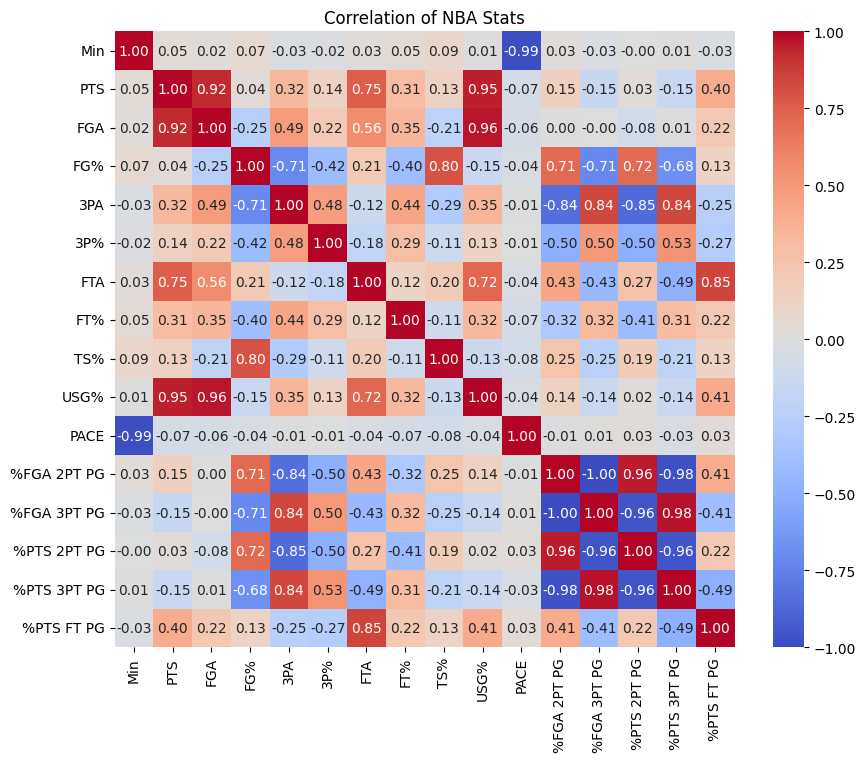

In [15]:
# Calculate the correlation matrix
cor_matrix = data.corr()

# Plot correlation heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of NBA Stats')
plt.show()

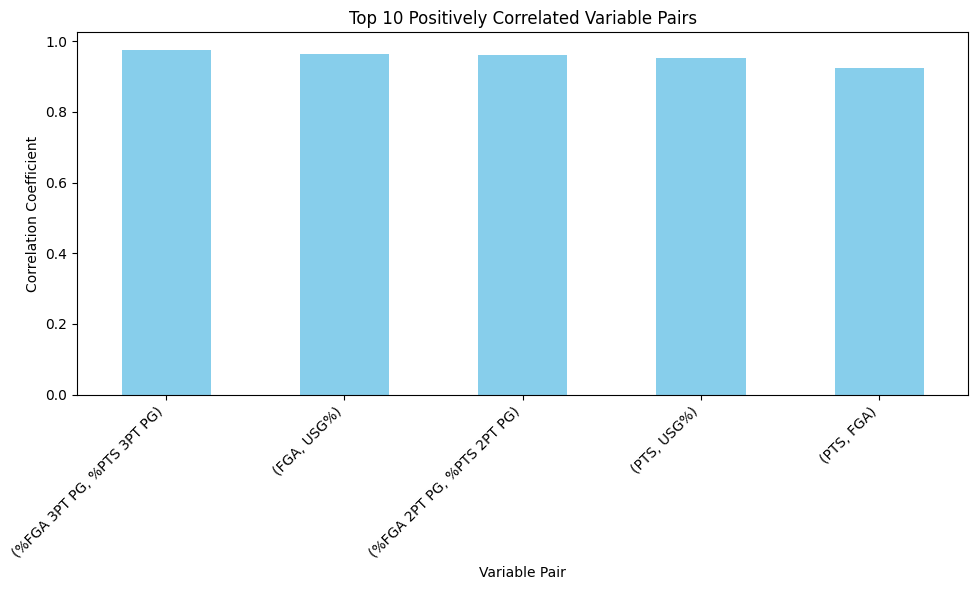

In [16]:
# Filter for positive correlations and exclude diagonal
positive_corr = cor_matrix.mask(np.tril(np.ones(cor_matrix.shape, dtype=bool))).stack().sort_values(ascending=False)

# Filter for significant correlations (greater than 0.9)
significant_corr = positive_corr[positive_corr > 0.9]

# Get the first 10 pairs of positively correlated variables
top_corr = significant_corr
# Plot the cross-correlation
plt.figure(figsize=(10, 6))
top_corr.plot(kind='bar', color='skyblue')
plt.title('Top 10 Positively Correlated Variable Pairs')
plt.xlabel('Variable Pair')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
significant_corr_pairs = []
for var1 in data.columns:
    for var2 in data.columns:
        if var1 < var2:
            corr, p_value = pearsonr(data[var1], data[var2])
            if np.abs(corr) > 0.5 and p_value < 0.05:  # Set the significance level at 5%
                significant_corr_pairs.append((var1, var2))

print(significant_corr_pairs)
plt.show()

[('Min', 'PACE'), ('PTS', 'USG%'), ('FGA', 'PTS'), ('FGA', 'FTA'), ('FGA', 'USG%'), ('FG%', 'TS%'), ('3PA', 'FG%'), ('FTA', 'PTS'), ('FTA', 'USG%'), ('%FGA 2PT PG', 'FG%'), ('%FGA 2PT PG', '3PA'), ('%FGA 2PT PG', '%FGA 3PT PG'), ('%FGA 2PT PG', '%PTS 2PT PG'), ('%FGA 2PT PG', '%PTS 3PT PG'), ('%FGA 3PT PG', 'FG%'), ('%FGA 3PT PG', '3PA'), ('%FGA 3PT PG', '%PTS 2PT PG'), ('%FGA 3PT PG', '%PTS 3PT PG'), ('%PTS 2PT PG', 'FG%'), ('%PTS 2PT PG', '3PA'), ('%PTS 2PT PG', '3P%'), ('%PTS 2PT PG', '%PTS 3PT PG'), ('%PTS 3PT PG', 'FG%'), ('%PTS 3PT PG', '3PA'), ('%PTS 3PT PG', '3P%'), ('%PTS FT PG', 'FTA')]


This code is performing cross-correlation analysis on pairs of variables in a dataset to identify significant correlations based on the Pearson
correlation coefficient and p-value. Here's a breakdown of what the code is doing:

Iterating Over Columns: The code iterates over each
column (variable) in the dataset twice using nested loops. This way, it considers all possible pairs of variables.

Calculating Correlation: For each pair of variables (var1, var2), it calculates the Pearson correlation coefficient (corr) and the p-value (p_value) using the pearsonr function from the scipy.stats module.

Checking Significance: It checks if the absolute value of the correlation coefficient is greater than 0.5 and if the p-value is less than 0.05 (significance level set at 5%). If both conditions are met, the pair (var1, var2) is considered a significant correlation pair.

Storing Significant Pairs: The significant correlation pairs are stored in the significant_corr_pairs list.

Displaying Results: The first 10 significant correlation pairs are printed, and then plt.show() is called to display any plots (though there are no plots generated in the provided code).

A significant correlation means that there is a statistically meaningful relationship between two variables. In the context of the provided code, significance is determined based on two criteria:

Correlation Coefficient: The absolute value of the Pearson correlation coefficient (corr) must be greater than 0.5. This indicates a strong linear relationship between the variables.

P-value: The p-value (p_value) must be less than 0.05, which is a common significance level used in statistical hypothesis testing. A p-value below this threshold suggests that the observed correlation coefficient is unlikely to have occurred by random chance alone.

Keeping both pairs of variables in your dataset depends on the specific context of your analysis and your goals. Here are some considerations:

Relevance: Are the variables meaningful and relevant to your analysis? If the variables are not relevant to your research question or analysis objectives, it may be unnecessary to keep them in the dataset.

Collinearity: If two variables are highly correlated, they may provide redundant information. In some cases, multicollinearity (high correlation between predictors) can cause issues in statistical modeling, such as inflated standard errors or unstable coefficient estimates. In such cases, you may choose to keep only one of the correlated variables or consider techniques like principal component analysis (PCA) to reduce dimensionality.

Interpretability: Consider whether the correlation between the variables makes sense in the context of your data and domain knowledge. Sometimes, statistically significant correlations may not have a clear causal explanation or practical significance.

Data Quality: Ensure that the observed correlations are not artifacts of data quality issues, such as outliers or measurement errors. It's important to carefully examine the data and consider potential confounding variables.

Ultimately, the decision to keep or remove correlated pairs of variables should be guided by your research objectives, domain knowledge, and the specific requirements of your analysis. If in doubt, it's often helpful to consult with domain experts or statisticians for guidance.

##Good news! I tried signifance levels of 1%, 10%, and 30% and calculated the same number of signficant corr pairs! Per chatgpt: Overall,observing the same number of significant correlations across different significance levels suggests that the relationships between variables are likely to be meaningful and robust. This suggests that the observed correlations are likely to be genuine and not simply due to random chance.However, it's important to interpret the results in conjunction with other factors and consider the implications for the research question and subsequent analyses.


# Boxplot Analysis - Non-Scaled Data

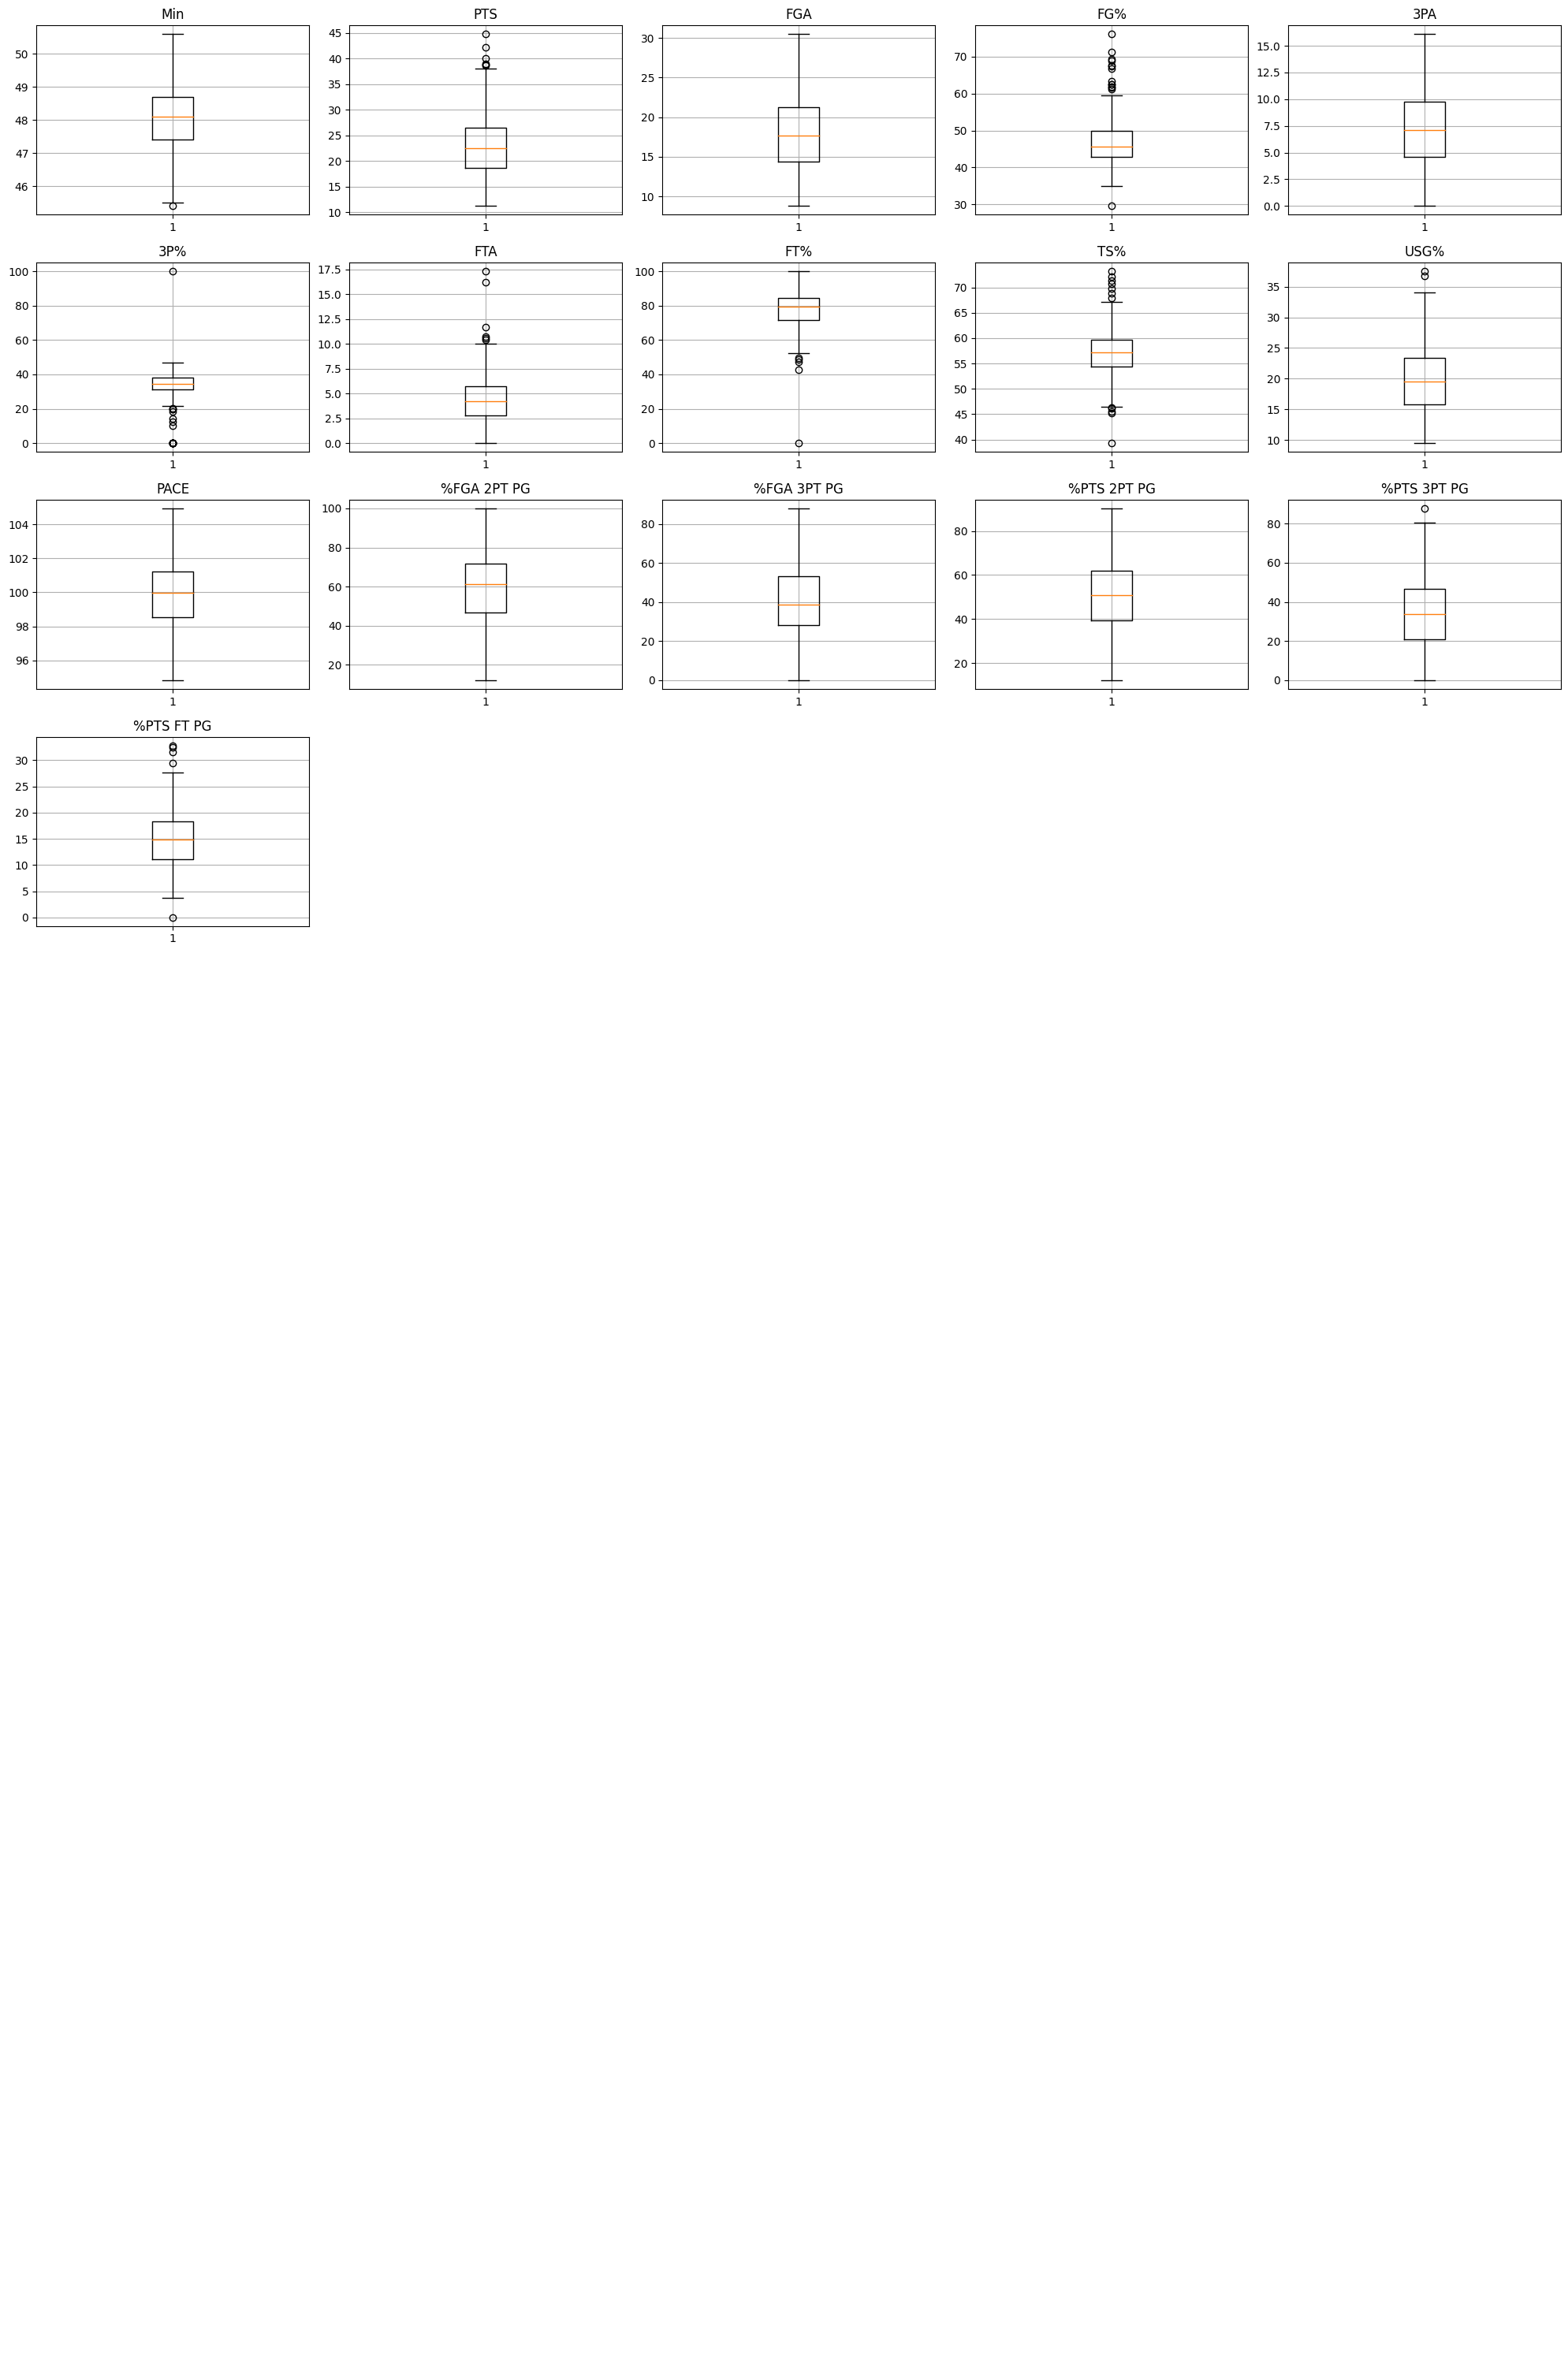

In [18]:
num_cols = data.shape[1]
num_rows = 10
num_cols_per_row = 5

# Create a figure and axes
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(20, 30))

# Flatten the axes array to simplify iteration
axes = axes.flatten()

# Iterate over columns and create boxplots
for i, col in enumerate(data.columns):
    ax = axes[i]
    ax.boxplot(data[col])
    ax.set_title(col)
    ax.grid(True)

# Hide any empty subplots
for i in range(num_cols, num_rows * num_cols_per_row):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



# Scaling! After this, data is converted from df to an array

In [19]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Implement k-means clustering algorithm with original data

In [20]:
# Define the range of k values
k_values = range(2,14)

# Dictionary to store the evaluation metrics for each k
#The average silhouette score is commonly used to evaluate
#the overall quality of clustering across different numbers of clusters.
#can run other methods take a look at elbow method and intercluster distance maps by yellowbrick
silhouette_scores_data = {}
calinski_scores_data = {}

# Run k-means clustering 10 times for each k
for k in k_values:
    silhouette_scores_data[k] = []
    calinski_scores_data[k] = []
    for i in range(10):
        #Increasing n_init may provide a more stable and reliable solution
        #by exploring a larger range of initializations. It can help
        #mitigate the risk of getting stuck in a local minimum and improve the
        #chance of finding a solution closer to the global minimum of inertia.
        #n_init defaults to 10, higher numbers will cost a lot more...
        #50 is considered relatively large. try it and see what resources stand or not
        # Random state = None to ensure different seeds; centroids will be initialized
        #randomly each time you run the algorithm. (exploratory)
        # Random state = integer value to ensure different seeds; centroids will be initialized
        #randomly each time you run the algorithm. (need reproducability)
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=None)
        labels = kmeans.fit_predict(data)
        # Calculate silhouette score
        silhouette = silhouette_score(data, labels)
        silhouette_scores_data[k].append(silhouette)
#        avg_ss_data_pca[k].append(avg_ss)
        # Calculate Calinski-Harabasz score
        calinski = calinski_harabasz_score(data, labels)
        calinski_scores_data[k].append(calinski)

# Select the best performing clustering output for each k
best_silhouette_data = {k: max(silhouette_scores_data[k]) for k in silhouette_scores_data}

best_calinski_data = {k: max(calinski_scores_data[k]) for k in calinski_scores_data}

# Print the best silhouette and Calinski-Harabasz scores for each k
print("Best Silhouette Scores:")
for k, score in best_silhouette_data.items():
    print(f"k={k}: {score:.4f}")

print("\nBest Calinski-Harabasz Scores:")
for k, score in best_calinski_data.items():
  print(f"k={k}: {score:.4f}")




Best Silhouette Scores:
k=2: 0.2466
k=3: 0.2451
k=4: 0.2398
k=5: 0.2153
k=6: 0.2052
k=7: 0.2018
k=8: 0.2028
k=9: 0.1939
k=10: 0.1980
k=11: 0.1943
k=12: 0.1949
k=13: 0.1898

Best Calinski-Harabasz Scores:
k=2: 95.1150
k=3: 95.7153
k=4: 87.2138
k=5: 79.5430
k=6: 72.3281
k=7: 67.0384
k=8: 63.8799
k=9: 60.8088
k=10: 58.3384
k=11: 56.0689
k=12: 53.3759
k=13: 51.4716


In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
for k in k_values:
  kmeans = KMeans(n_clusters=k, n_init=10, random_state=None)
  visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
  visualizer.fit(data)
   # Fit the data to the visualizer
  visualizer.show()
  # Finalize and render the figure

In [49]:
## At this point, you should choose how many clusters you want and you repeat with that n_clusters
#consider set random state?
k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=None)
kmeans.fit_predict(data)
cluster_labels = kmeans.labels_
Players_2122['Cluster'] = cluster_labels

# # Define cluster names
cluster_names = {
     0: 'A',
     1: 'B',
     2: 'C',
     3: 'D'
     }

Players_2122['Cluster'] = Players_2122['Cluster'].map(cluster_names)
Cluster1_data = Players_2122.groupby('Cluster')

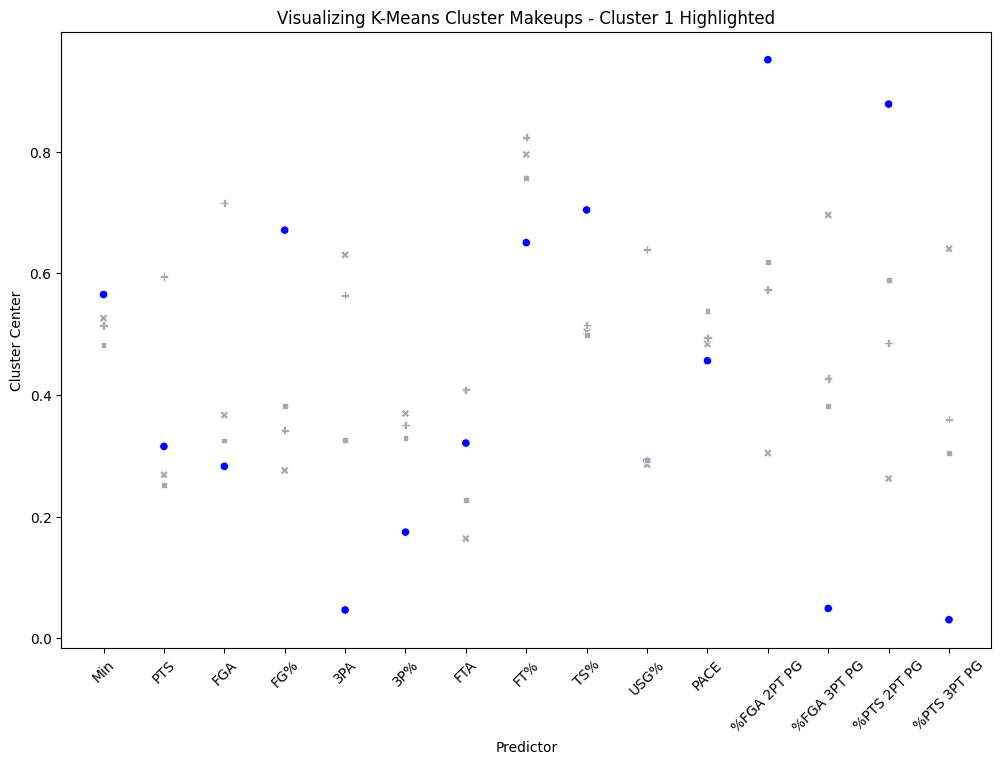

In [28]:
km_centers = pd.DataFrame(kmeans.cluster_centers_)  # SCALED cluster centers/means
km_centers = km_centers.rename(columns=dict(zip(km_centers.columns[:15], data_col_names)))
# Name clusters before pivoting
km_centers['Cluster'] = [f'Cluster {i+1}' for i in range(k)]

# Pivot data for plotting
km_centers_melted = km_centers.melt(id_vars=['Cluster'], var_name='feature', value_name='z_val')

# Reset the order of predictor variables for plotting
km_centers_melted['feature'] = pd.Categorical(km_centers_melted['feature'],
                                              categories=['Min', 'PTS', 'FGA', 'FG%', '3PA', '3P%', 'FTA', 'FT%', 'TS%', 'USG%',
                                                          'PACE', '%FGA 2PT PG', '%FGA 3PT PG', '%PTS 2PT PG', '%PTS 3PT PG','%PTS FT PG'], ordered=True)

# Reset the order of clusters for plotting
km_centers_melted['Cluster'] = pd.Categorical(km_centers_melted['Cluster'],
                                              categories=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], ordered=True)

# Visualize cluster centers in a plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='feature', y='z_val', data=km_centers_melted, hue='Cluster', style='Cluster', palette=['blue', 'darkgray','darkgray','darkgray'])
plt.xlabel('Predictor')
plt.ylabel('Cluster Center')
plt.title('Visualizing K-Means Cluster Makeups - Cluster 1 Highlighted')
plt.xticks(rotation=45)
plt.legend().remove()  # Remove legend
plt.show()


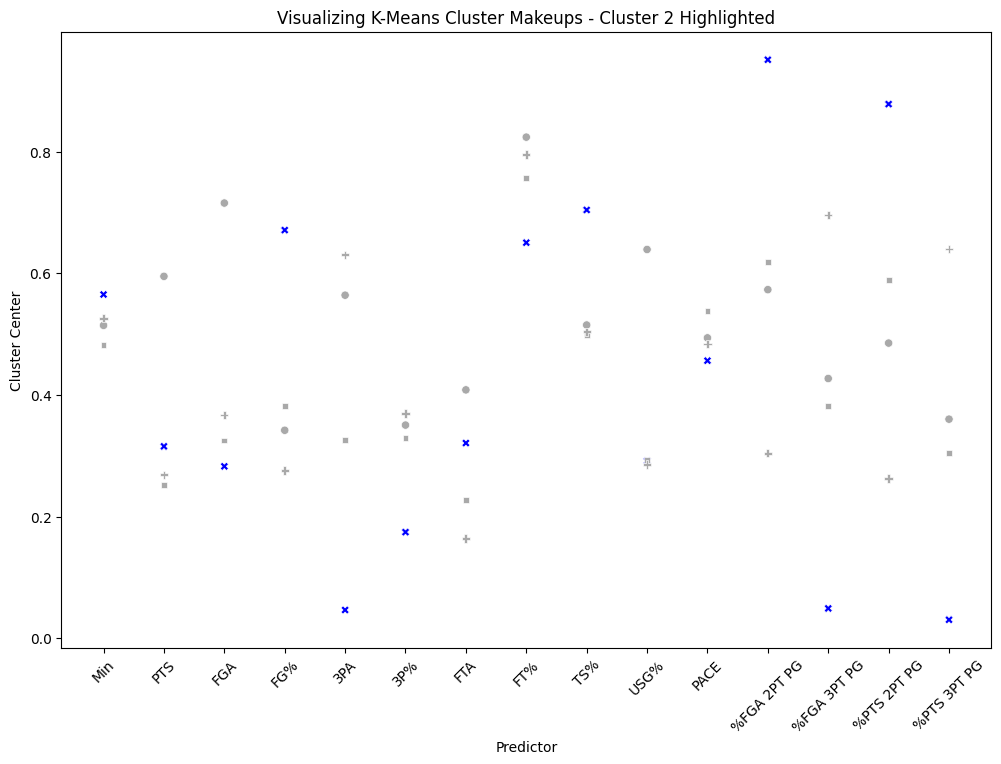

In [24]:
# Visualize cluster centers in a plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='feature', y='z_val', data=km_centers_melted, hue='Cluster', style='Cluster', palette=['darkgray', 'blue','darkgray','darkgray'])
plt.xlabel('Predictor')
plt.ylabel('Cluster Center')
plt.title('Visualizing K-Means Cluster Makeups - Cluster 2 Highlighted')
plt.xticks(rotation=45)
plt.legend().remove()  # Remove legend
plt.show()

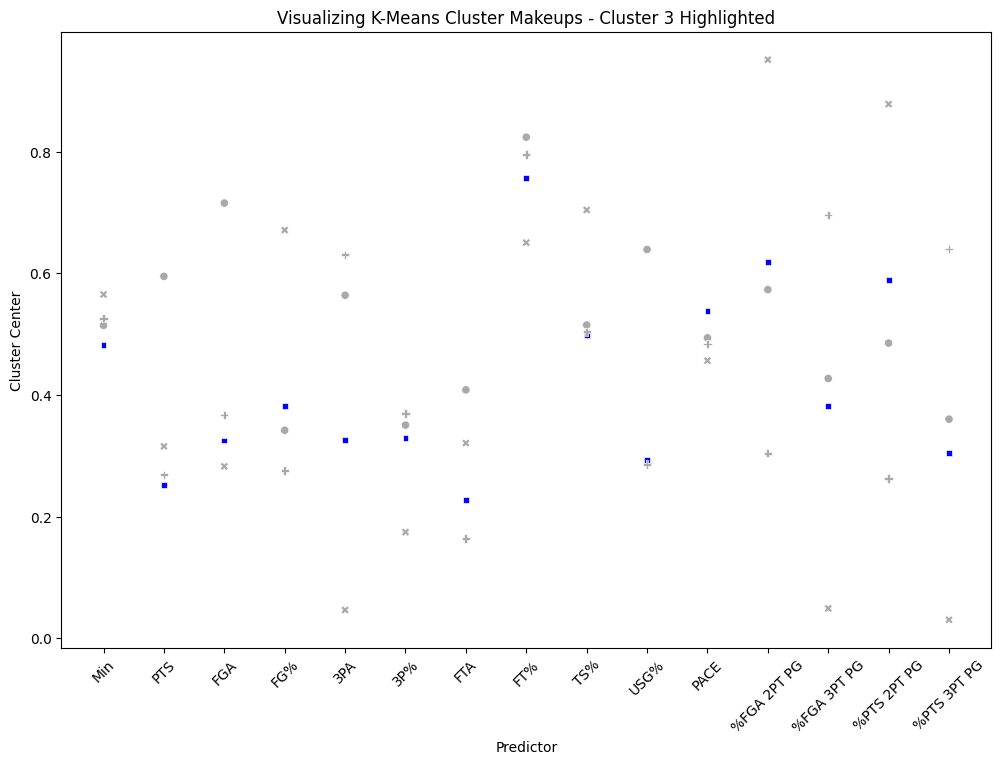

In [25]:
# Visualize cluster centers in a plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='feature', y='z_val', data=km_centers_melted, hue='Cluster', style='Cluster', palette=['darkgray', 'darkgray','blue','darkgray'])
plt.xlabel('Predictor')
plt.ylabel('Cluster Center')
plt.title('Visualizing K-Means Cluster Makeups - Cluster 3 Highlighted')
plt.xticks(rotation=45)
plt.legend().remove()  # Remove legend
plt.show()

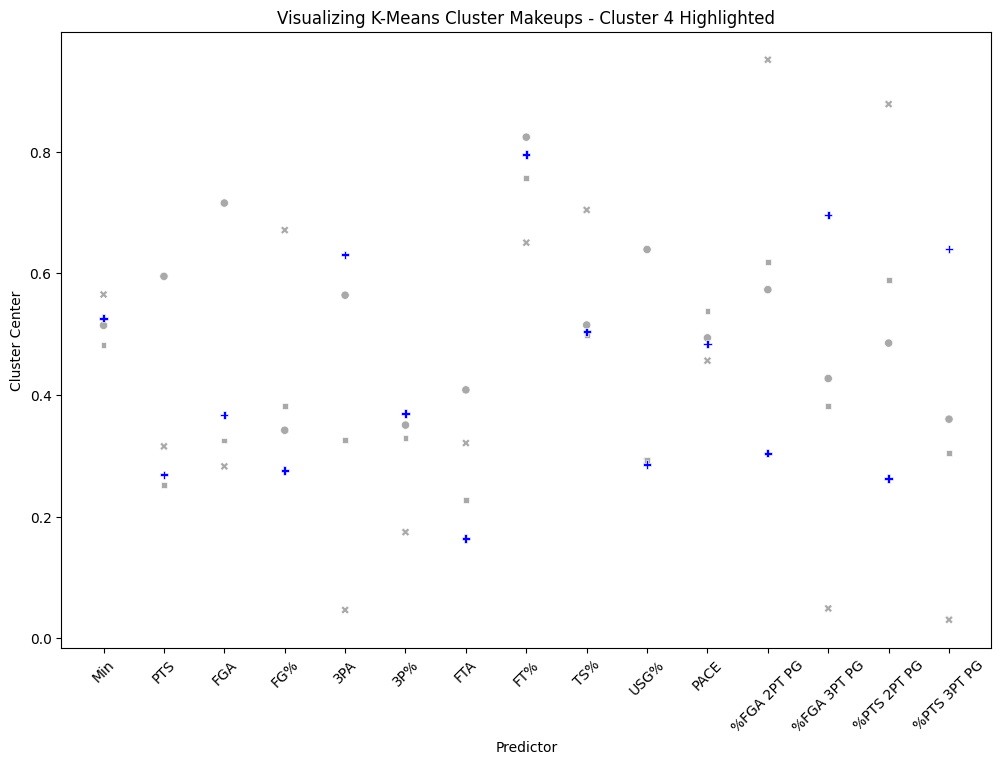

In [26]:
# Visualize cluster centers in a plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='feature', y='z_val', data=km_centers_melted, hue='Cluster', style='Cluster', palette=['darkgray', 'darkgray','darkgray','blue'])
plt.xlabel('Predictor')
plt.ylabel('Cluster Center')
plt.title('Visualizing K-Means Cluster Makeups - Cluster 4 Highlighted')
plt.xticks(rotation=45)
plt.legend().remove()  # Remove legend
plt.show()

# Perform Principal Component Analysis (PCA)

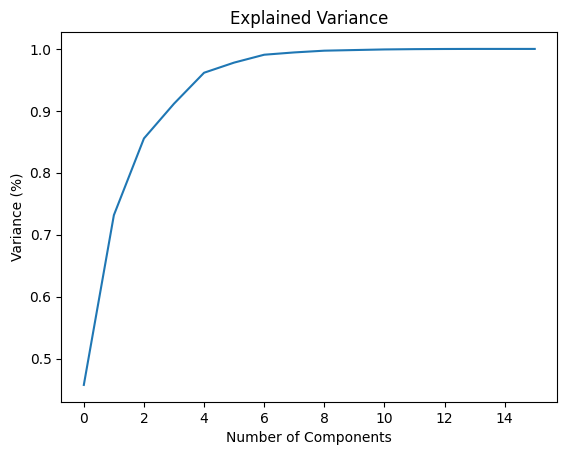

In [29]:
pca = PCA().fit(data)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()
# number of components to use looks like 7

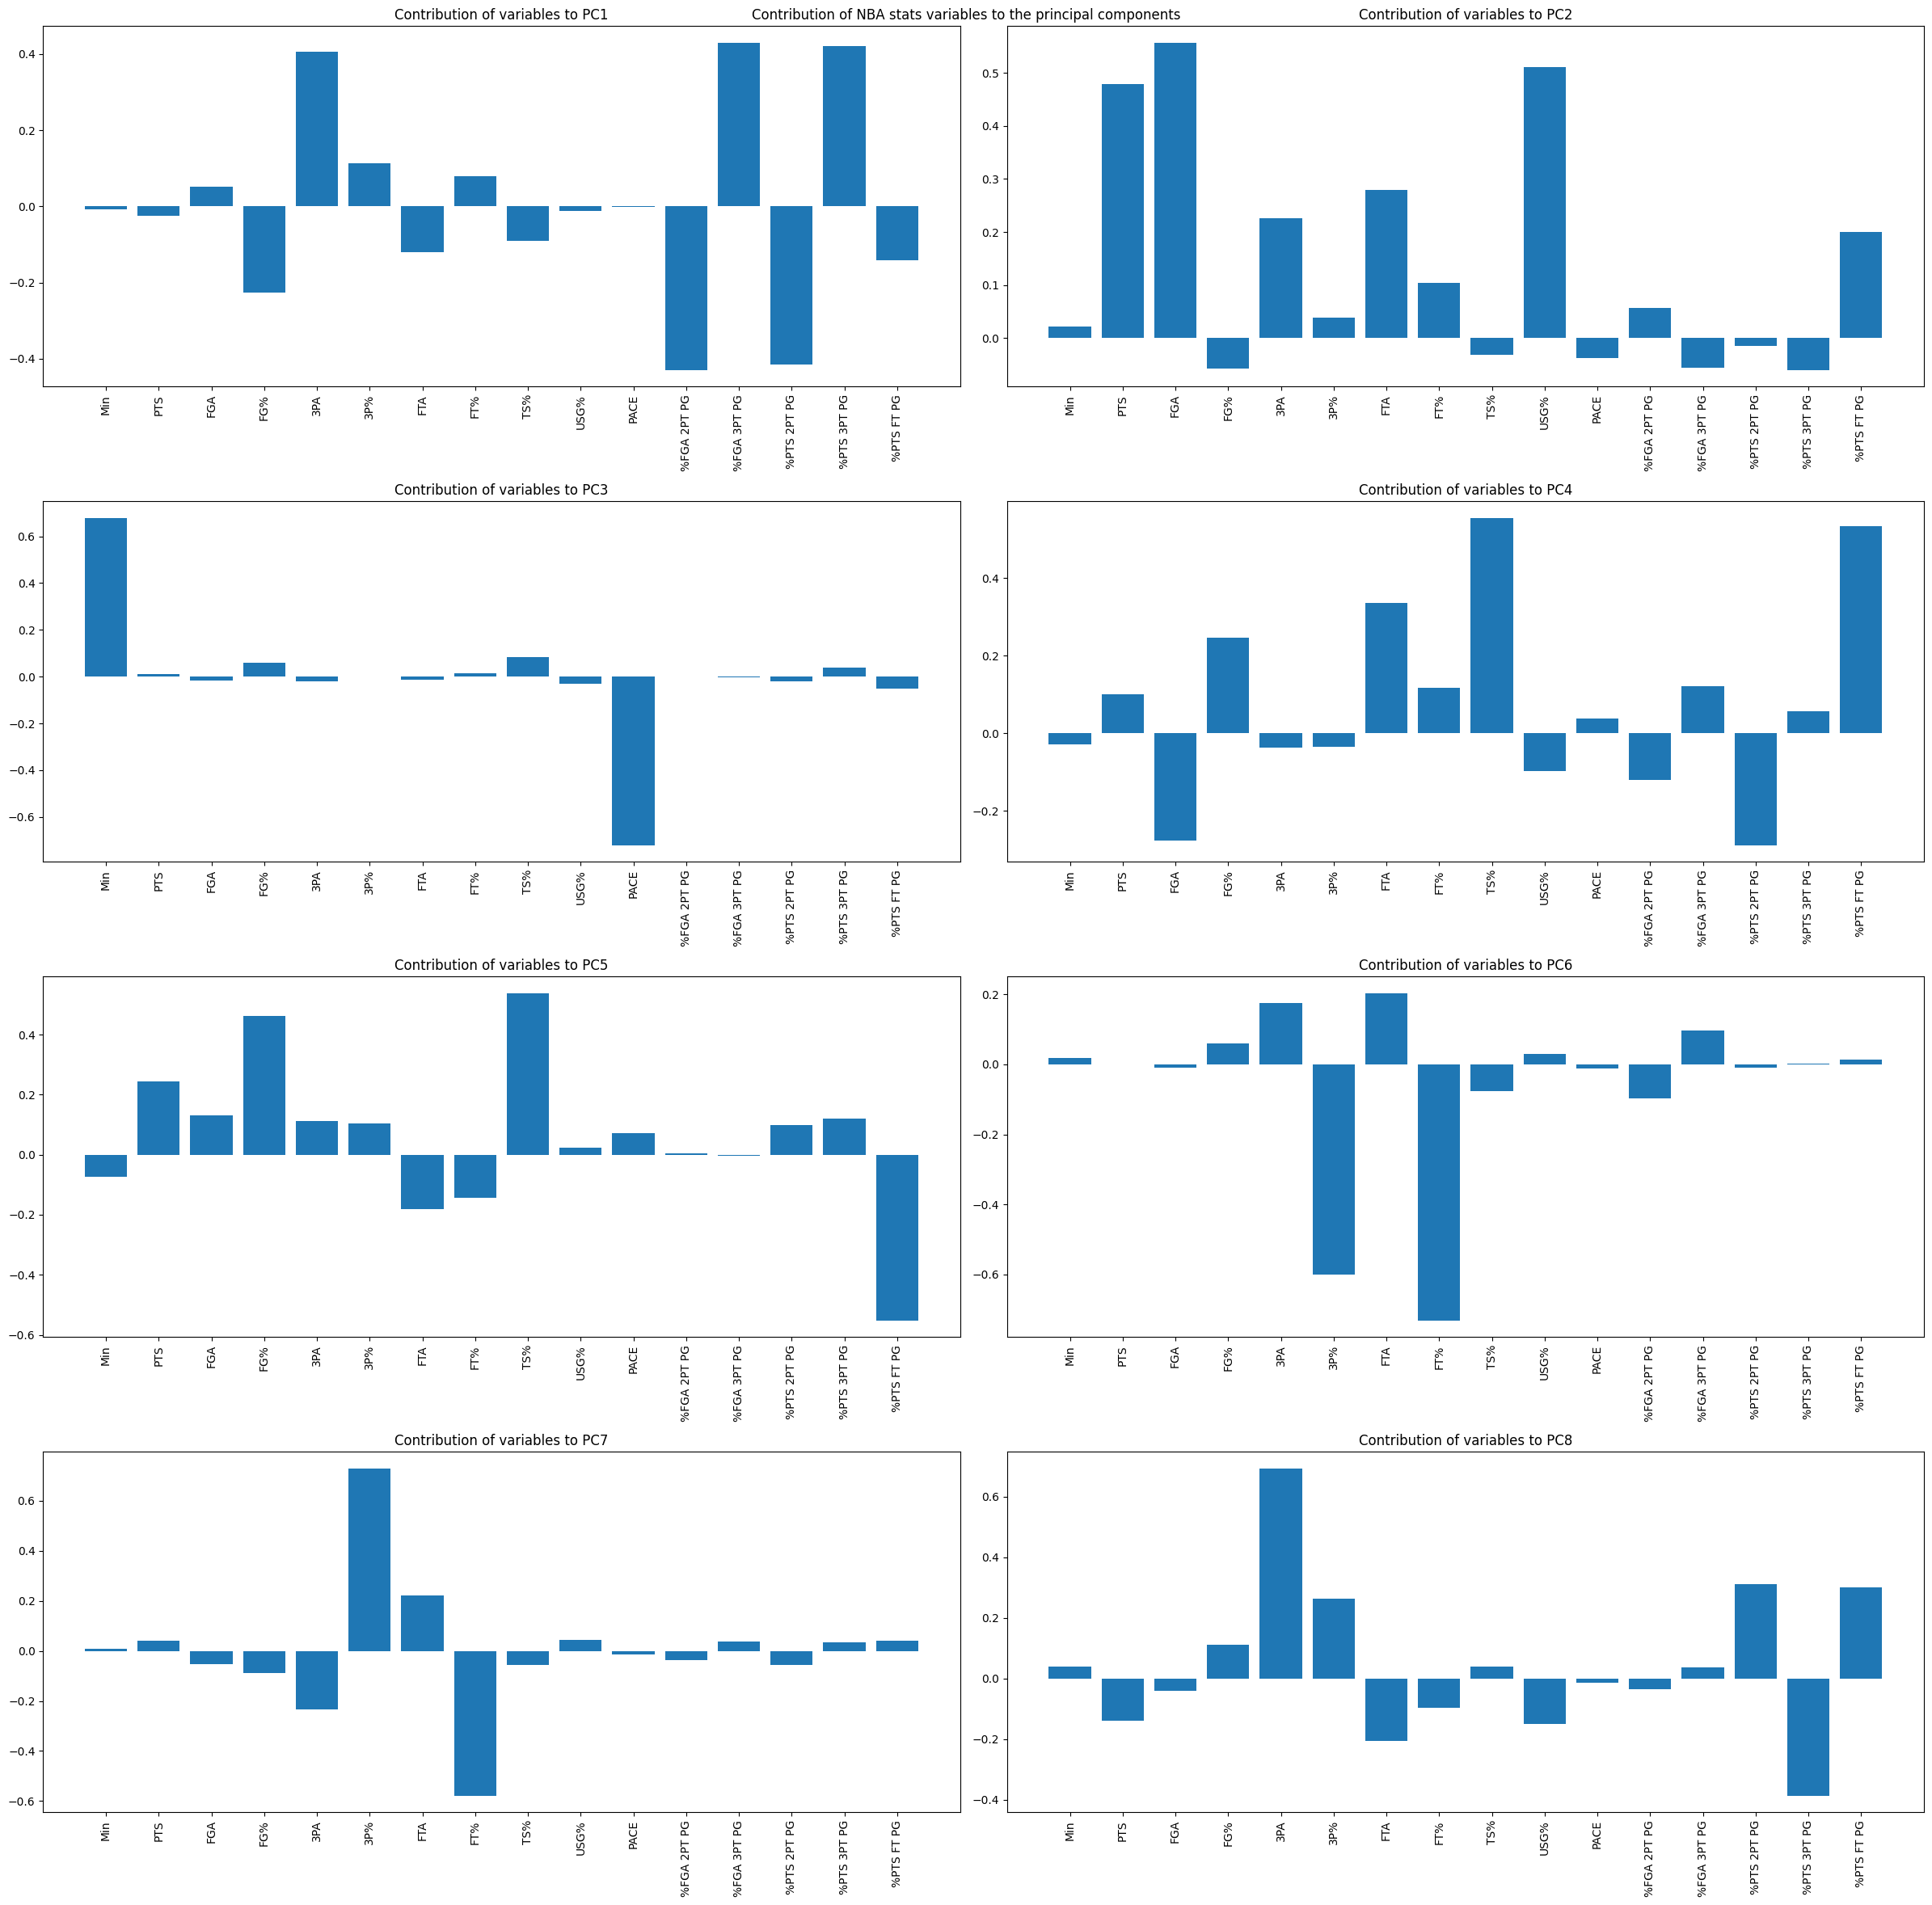

In [30]:
pca = PCA(n_components=8)
pca.fit_transform(data)
cluster1_var = round(pca.explained_variance_ratio_[0], 4) * 100
cluster2_var = round(pca.explained_variance_ratio_[1], 4) * 100
km_centers = pd.DataFrame(kmeans.cluster_centers_)  # SCALED cluster centers/means

data_pca = pca.fit_transform(data)
with open('data_pca_n8.pkl', 'wb') as f:
    pickle.dump(data_pca, f)

#'pca' is dtype = decomposition
#'data_pca' is array with dtype float 64
components = pca.components_

num_pcs = 8
num_vars = components.shape[1]
num_rows = 4

plt.figure(figsize=(24,24))  # Adjust the figure size as needed

for i in range(num_pcs):
    plt.subplot(num_rows, (num_pcs + num_rows - 1) // num_rows, i+1)  # Create subplots in rows
    plt.bar(range(num_vars), components[i])
    plt.xticks(range(num_vars), data_col_names,rotation=90)  # Rotate x-axis labels for better readability
    plt.title(f'Contribution of variables to PC{i+1}')

plt.suptitle('Contribution of NBA stats variables to the principal components')
plt.tight_layout()
plt.show()

# Implement k-means clustering algorithm with PCA data



From Onay and oskey: We run our k-means algorithm for all values of k between 5 and 35. To account for the potential impact of random centroid seeds on the cluster robustness, we run each clustering instance of the algorithm 10 times, with different random seeds, selecting the best performing clustering output,
using Python’s scikit learn library. For each of these clustering outputs,
we estimate the cluster validity using Silhouette value and Calinski-Harabasz
pseudo-F index for each run of the algorithm (Chan et al., 2012). Using these
two validity indices, we identify best performing k values as k = 25 and k = 26.
We also recognise that Bezdek and Bezdek (1981) shows that no cluster validity
measure is able to capture the correct number of underlying clusters
in every case. Therefore, we also randomly sample other k values to use as
inputs for our predictors. We find that as the k value deviates
from the 25–26 range in either direction, the prediction success drops.


In [ ]:
# Define the range of k values
k_values = range(2,14)

# Dictionary to store the evaluation metrics for each k
#The average silhouette score is commonly used to evaluate
#the overall quality of clustering across different numbers of clusters.
#can run other methods take a look at elbow method and intercluster distance maps by yellowbrick
silhouette_scores_data_pca = {}
calinski_scores_data_pca = {}

# Run k-means clustering 10 times for each k
for k in k_values:
    silhouette_scores_data_pca[k] = []
    calinski_scores_data_pca[k] = []
    for i in range(10):
        #Increasing n_init may provide a more stable and reliable solution
        #by exploring a larger range of initializations. It can help
        #mitigate the risk of getting stuck in a local minimum and improve the
        #chance of finding a solution closer to the global minimum of inertia.
        #n_init defaults to 10, higher numbers will cost a lot more...
        #50 is considered relatively large. try it and see what resources stand or not
        # Random state = None to ensure different seeds; centroids will be initialized
        #randomly each time you run the algorithm. (exploratory)
        # Random state = integer value to ensure different seeds; centroids will be initialized
        #randomly each time you run the algorithm. (need reproducability)
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=None)
        labels = kmeans.fit_predict(data_pca)
        # Calculate silhouette score
        silhouette = silhouette_score(data_pca, labels)
        silhouette_scores_data_pca[k].append(silhouette)
#        avg_ss_data_pca[k].append(avg_ss)
        # Calculate Calinski-Harabasz score
        calinski = calinski_harabasz_score(data_pca, labels)
        calinski_scores_data_pca[k].append(calinski)

# Select the best performing clustering output for each k
best_silhouette_data_pca = {k: max(silhouette_scores_data_pca[k]) for k in silhouette_scores_data_pca}

best_calinski_data_pca = {k: max(calinski_scores_data_pca[k]) for k in calinski_scores_data_pca}

# Print the best silhouette and Calinski-Harabasz scores for each k
print("Best Silhouette Scores:")
for k, score in best_silhouette_data_pca.items():
    print(f"k={k}: {score:.4f}")

print("\nBest Calinski-Harabasz Scores:")
for k, score in best_calinski_data_pca.items():
  print(f"k={k}: {score:.4f}")




In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
for k in k_values:
  kmeans = KMeans(n_clusters=k, n_init=10, random_state=None)
  visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
  visualizer.fit(data_pca)
   # Fit the data to the visualizer
  visualizer.show()
  # Finalize and render the figure



A clustering with an average silhouette width of over 0.7 is considered to be "strong", a value over 0.5 "reasonable" and over 0.25 "weak", but with increasing dimensionality of the data, it becomes difficult to achieve such high values because of the curse of dimensionality, as the distances become more similar.

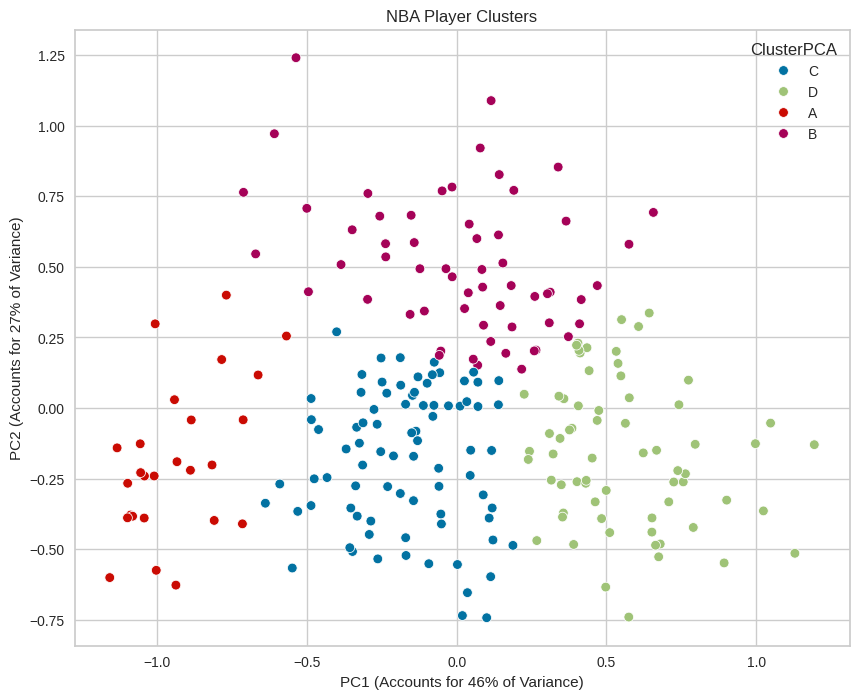

In [53]:
## At this point, you should choose how many clusters you want and you repeat with that n_clusters
#consider set random state?
k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=None)
kmeans.fit_predict(data_pca)
cluster_labels = kmeans.labels_
Players_2122['ClusterPCA'] = cluster_labels

# # Define cluster names
cluster_names = {
     0: 'A',
     1: 'B',
     2: 'C',
     3: 'D'
     }

Players_2122['ClusterPCA'] = Players_2122['ClusterPCA'].map(cluster_names)
Cluster1_data_pca = Players_2122.groupby('ClusterPCA')
# Plotting Clusters
plt.figure(figsize=(10, 8))
# Extract first two Principal Components
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=Players_2122['ClusterPCA'])
plt.title('NBA Player Clusters')
plt.xlabel(f'PC1 (Accounts for {round(cluster1_var)}% of Variance)')
plt.ylabel(f'PC2 (Accounts for {round(cluster2_var)}% of Variance)')
plt.show()

In [52]:
Players_2122

,Player,Min,PTS,FGA,FG%,3PA,3P%,FTA,FT%,TS%,USG%,PACE,%FGA 2PT PG,%FGA 3PT PG,%PTS 2PT PG,%PTS 3PT PG,%PTS FT PG,Cluster,ClusterPCA
0,Aaron Gordon,48.4,22.9,17.0,52.0,5.3,33.5,4.7,74.3,60.2,19.4,99.00,68.8,31.2,61.6,23.2,15.2,C,B
1,Aaron Holiday,48.3,18.9,16.0,44.7,4.9,37.9,3.2,86.8,54.4,18.2,99.57,69.5,30.5,56.0,29.3,14.7,C,B
2,Aaron Nesmith,48.0,16.4,15.2,39.6,9.6,27.0,2.2,80.8,50.7,16.4,100.58,36.8,63.2,41.8,47.4,10.8,A,C
3,Aaron Wiggins,47.5,16.3,13.2,46.3,5.4,30.4,3.3,72.9,55.6,14.9,101.60,59.1,40.9,54.8,30.3,14.9,C,B
4,Al Horford,48.9,17.1,13.9,46.7,6.5,33.6,2.3,84.2,57.4,14.7,98.03,53.4,46.6,50.5,38.1,11.4,C,B
5,Alec Burks,49.4,20.1,15.5,39.1,8.3,40.4,5.6,82.2,55.9,17.1,96.97,46.6,53.4,27.1,49.9,23.0,A,C
6,Alex Caruso,48.3,12.8,10.8,39.8,5.3,33.3,3.1,79.5,52.8,13.0,99.49,50.8,49.2,39.5,41.4,19.1,C,B
7,Alperen Sengun,47.1,21.9,16.6,47.4,3.7,24.8,7.3,71.1,55.2,21.4,101.69,77.7,22.3,63.6,12.6,23.8,C,B
8,Amir Coffey,48.1,19.0,14.3,45.3,7.8,37.8,3.6,86.3,59.8,15.4,100.02,45.5,54.5,37.2,46.5,16.3,A,C
9,Andre Drummond,48.6,19.6,14.6,57.0,0.1,0.0,5.5,52.4,57.4,18.1,99.27,99.3,0.7,85.2,0.0,14.8,D,A


In [66]:
# Assuming 'df' is your DataFrame and 'column_name' is the column you want to group by
grouped = Players_2122.groupby('Cluster')

group_dict = {}

# Iterate over each group and store the group name and group DataFrame in the dictionary
for group_name, group_df in grouped:
    group_dict[group_name] = group_df

for group_name, group_df in group_dict.items():
    size = len(group_df)  # Get the number of rows in the DataFrame
    print(f"Group {group_name} has size: {size}")

Group A has size: 66
Group B has size: 59
Group C has size: 82
Group D has size: 26


#  Hierarchical Clustering

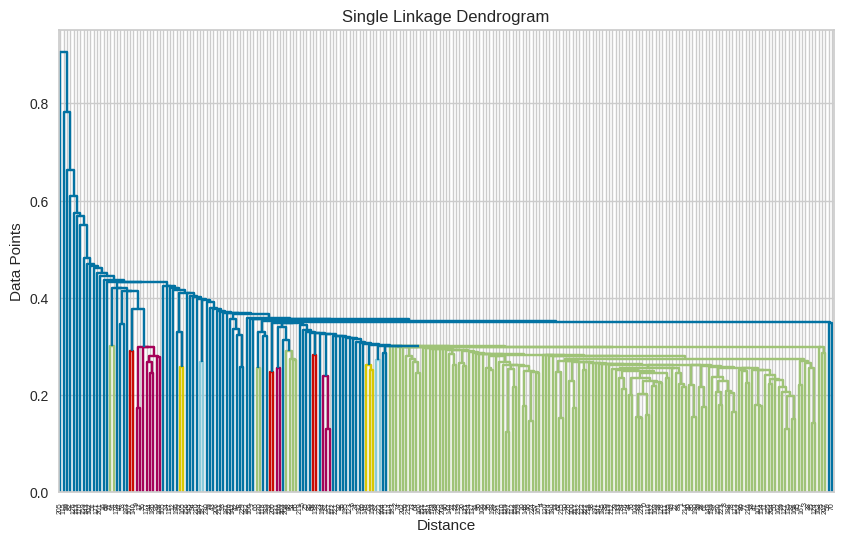

In [68]:
# Try clustering by single link, centroid, and ward (D2)

nba_dist = pdist(data, metric='euclidean')

hcl_single = linkage(y=nba_dist, method='single')
hcl_centroid = linkage(y=nba_dist, method='centroid')
#this is squared Euclidean distances
hcl_ward = linkage(y=nba_dist, method='ward')

# This is squared Euclidean distances
squared_dissimilarities = pdist(data, metric='sqeuclidean')
# Convert the result to a square distance matrix
hcl_ward_d2 = linkage(squared_dissimilarities, method='ward')

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
dendrogram(hcl_single, orientation='top', labels=None, color_threshold=0.3)
plt.title('Single Linkage Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Data Points')
plt.show()

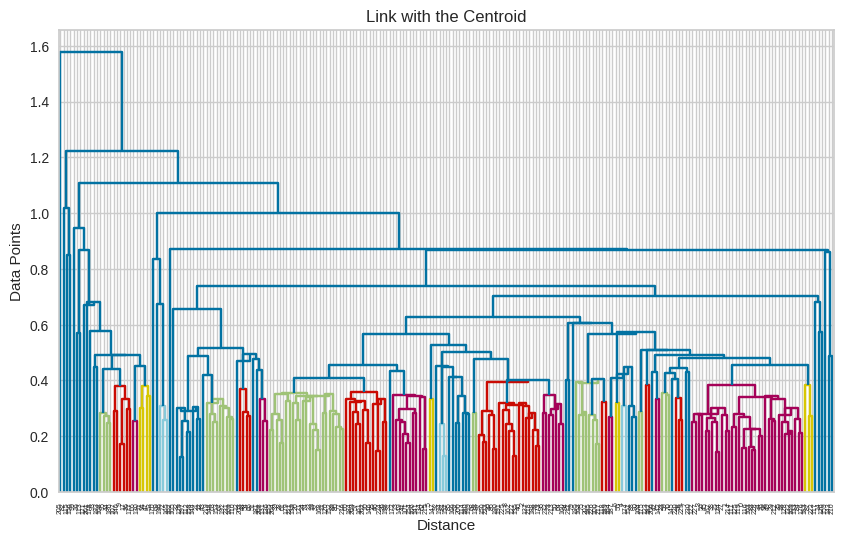

In [70]:
# Plot centroid linkage method
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
dendrogram(hcl_centroid, orientation='top', labels=None, color_threshold=0.4)
plt.title('Link with the Centroid')
plt.xlabel('Distance')
plt.ylabel('Data Points')
plt.show()


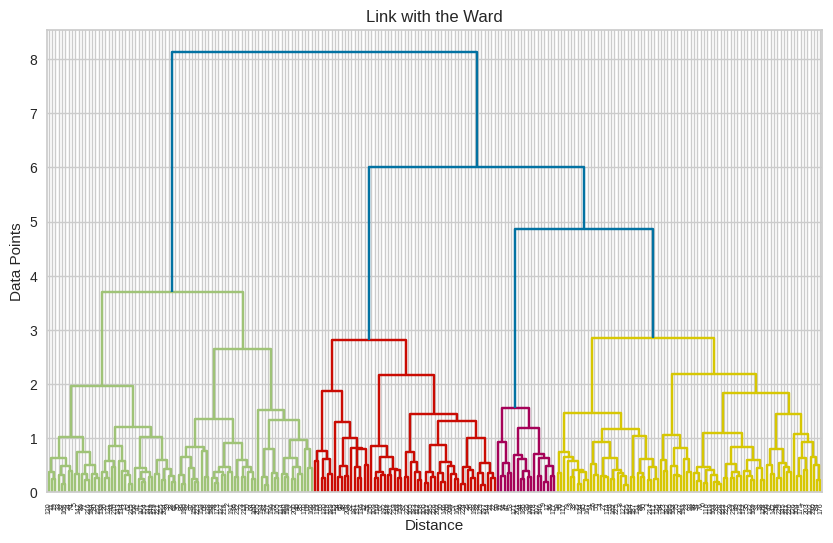

In [78]:
# Plot dendrogram for Ward
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
threshold = 4  # Adjust this threshold value as needed
dendrogram(hcl_ward, orientation='top', labels=None, color_threshold=threshold)
plt.title('Link with the Ward')
plt.xlabel('Distance')
plt.ylabel('Data Points')
plt.show()


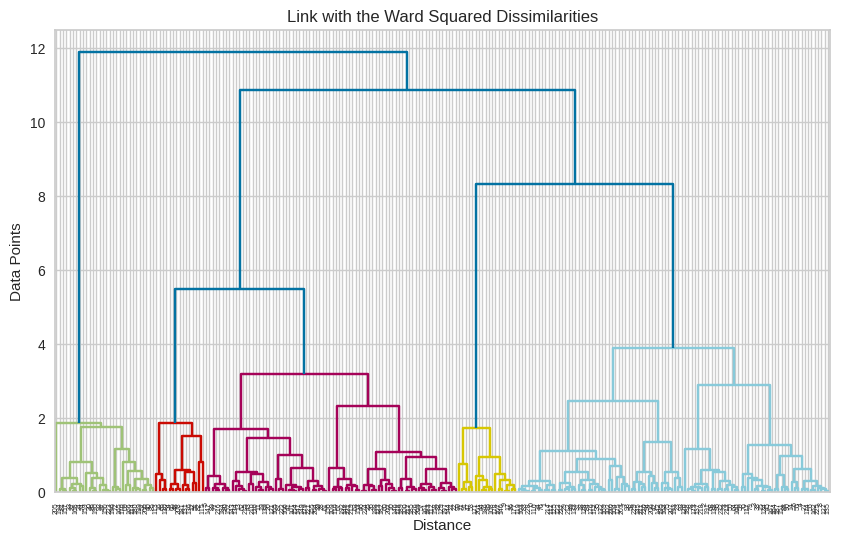

In [72]:
# Plot dendrogram for Ward D2
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
threshold =  4 # Adjust this threshold value as needed
dendrogram(hcl_ward_d2, orientation='top', labels=None, color_threshold=threshold)
plt.title('Link with the Ward Squared Dissimilarities')
plt.xlabel('Distance')
plt.ylabel('Data Points')
plt.show()


In [80]:
hclusters = fcluster(hcl_ward, threshold, criterion='distance')
hclusters

array([4, 4, 1, 4, 4, 1, 4, 4, 4, 3, 2, 1, 2, 1, 4, 4, 2, 3, 4, 1, 1, 2,
       2, 4, 1, 2, 2, 4, 1, 4, 1, 4, 2, 1, 4, 4, 3, 1, 4, 1, 1, 1, 4, 1,
       3, 4, 2, 3, 2, 4, 1, 2, 1, 3, 2, 4, 4, 2, 4, 4, 2, 1, 1, 2, 1, 2,
       2, 2, 1, 1, 4, 3, 1, 1, 1, 4, 4, 1, 1, 4, 1, 1, 2, 4, 4, 1, 1, 2,
       4, 1, 4, 3, 1, 4, 4, 3, 1, 1, 4, 3, 2, 1, 4, 4, 4, 2, 1, 3, 3, 2,
       2, 4, 2, 2, 1, 2, 4, 4, 2, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2,
       4, 4, 1, 4, 2, 1, 1, 1, 3, 1, 4, 1, 2, 4, 2, 1, 2, 1, 1, 4, 1, 2,
       1, 1, 2, 1, 2, 1, 1, 2, 4, 4, 4, 1, 1, 4, 1, 4, 1, 3, 4, 1, 4, 4,
       4, 3, 3, 1, 1, 2, 4, 2, 1, 2, 3, 4, 1, 2, 1, 1, 2, 4, 1, 4, 1, 2,
       2, 1, 1, 3, 2, 4, 1, 1, 4, 4, 2, 2, 1, 4, 4, 1, 4, 1, 1, 2, 1, 2,
       4, 1, 2, 1, 2, 4, 2, 4, 4, 4, 4, 2, 1], dtype=int32)

In [ ]:
Players_2122['HCluster'] = hclusters
Players_2122['HCluster']
# # Define cluster names
cluster_names = {
     0: 'A',
     1: 'B',
     2: 'C',
     3: 'D'
     }

Players_2122

In [91]:
# prompt: Using dataframe Players_2122:

Players_2122.groupby('Cluster')['PTS'].mean().reset_index().sort_values('PTS', ascending=False)


,Cluster,PTS
1,B,31.189831
3,D,21.796154
0,A,20.225758
2,C,19.685366


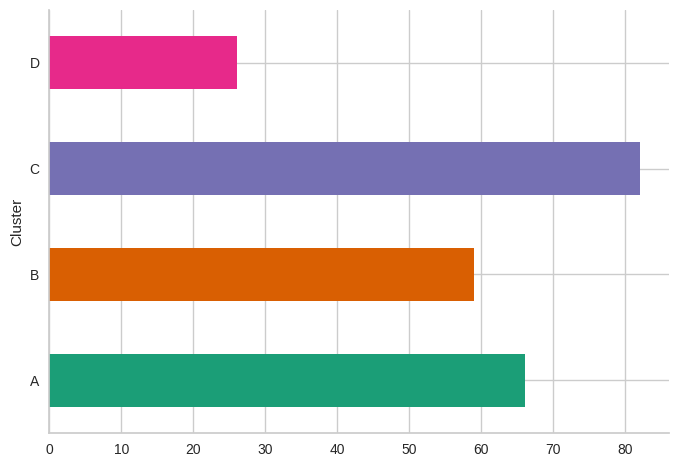

In [90]:
# @title Cluster
Players_2122.groupby('Cluster').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

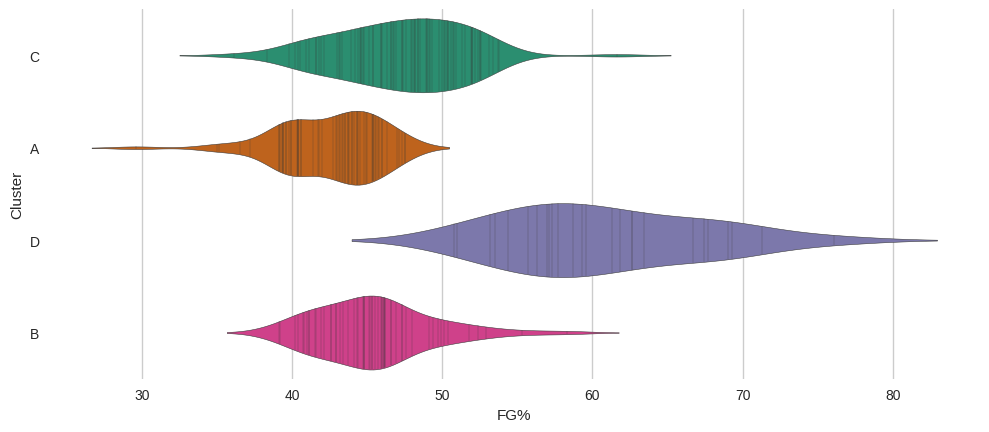

In [88]:
figsize = (12, 1.2 * len(Players_2122['Cluster'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(Players_2122, x='FG%', y='Cluster', hue=Players_2122['Cluster'], legend=False, inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)